In [53]:
#!/usr/bin python3
import itertools
import json
import numpy as np
import pandas as pd
import random
from sklearn import metrics
import seaborn as sns
from tabulate import tabulate
import torch
import torch.backends.mps
from torch.utils.data import DataLoader

from utils import data_utils, data_loader, model_utils
from models import avg_speed, avg_speed_seq, time_table, basic_ff, basic_rnn

import importlib

run_folder = "../results/throwaway/"
network_folder = "kcm/"

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

### Set run and hyperparameters
EPOCHS = 50
BATCH_SIZE = 512
LEARN_RATE = 1e-3
HIDDEN_SIZE = 32
SEQ_LEN = 2

### Load train/test data
print("="*30)
data_folder = run_folder + network_folder + "deeptte_formatted/"
print(f"Loading data from '{data_folder}'...")
# Load config
with open(data_folder + "config.json", "r") as f:
    config = json.load(f)
# Load GTFS-RT samples
train_data_chunks, valid_data = data_utils.load_train_test_data(data_folder, config['n_folds']) # Validation data no longer used
# Load GTFS data
print(f"Loading and merging GTFS files from '{config['gtfs_folder']}'...")
gtfs_data = data_utils.merge_gtfs_files("."+config['gtfs_folder'])

Using device: mps
Loading data from '../results/throwaway/kcm/deeptte_formatted/'...
Loading and merging GTFS files from './data/kcm_gtfs/2020_09_23/'...


In [54]:
fold_num = 0
importlib.reload(data_loader)
# Set aside the train/test data according to the current fold number
test_data = train_data_chunks[fold_num]
train_data = [x for i,x in enumerate(train_data_chunks) if i!=fold_num]
# Combine the training data to single object
train_data = list(itertools.chain.from_iterable(train_data))

# Construct dataloaders for Pytorch models
train_dataset = data_loader.make_dataset(train_data, config)
test_dataset = data_loader.make_dataset(test_data, config)
train_dataset_seq = data_loader.make_seq_dataset(train_data, config, SEQ_LEN)
test_dataset_seq = data_loader.make_seq_dataset(test_data, config, SEQ_LEN)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False, num_workers=0)
train_dataloader_seq = DataLoader(train_dataset_seq, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False, num_workers=0)
test_dataloader_seq = DataLoader(test_dataset_seq, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False, num_workers=0)
print(f"Successfully loaded {len(train_data)} training samples and {len(test_data)} testing samples.")

# Define embedded variables for nn models
embed_dict = {
    'timeID': {
        'vocab_size': 1440,
        'embed_dims': 24,
        'col': 8
    },
    'weekID': {
        'vocab_size': 7,
        'embed_dims': 4,
        'col': 9
    },
    'driverID': {
        'vocab_size': config['n_unique_veh'],
        'embed_dims': 12,
        'col': 10
    }
}

Successfully loaded 39262 training samples and 9814 testing samples.


In [55]:
importlib.reload(avg_speed)
avg_model = avg_speed.AvgHourlySpeedModel(config)
avg_model.fit(train_dataloader)
avg_model.save_to(f"{run_folder}{network_folder}models/avg_model_{fold_num}.pkl")
avg_labels, avg_preds = avg_model.predict(test_dataloader)

In [56]:
importlib.reload(avg_speed_seq)
avg_seq_model = avg_speed_seq.AvgHourlySpeedSeqModel(config)
avg_seq_model.fit(train_dataloader_seq)
avg_seq_model.save_to(f"{run_folder}{network_folder}models/avg_model_{fold_num}.pkl")
avg_seq_labels, avg_seq_preds = avg_seq_model.predict(test_dataloader_seq)

In [57]:
rnn_model = basic_rnn.BasicRNN(
    # X tensor, first element, traj component, n_features
    train_dataloader_seq.dataset.tensors[0][0][0].shape[1],
    1,
    HIDDEN_SIZE,
    BATCH_SIZE,
    embed_dict
).to(device)
rnn_train_losses, rnn_test_losses = model_utils.fit_to_data(rnn_model, train_dataloader_seq, test_dataloader_seq, LEARN_RATE, EPOCHS, config, device, sequential_flag=True)
torch.save(rnn_model.state_dict(), run_folder + network_folder + f"models/rnn_model_{fold_num}.pt")
rnn_labels, rnn_preds, rnn_avg_loss = model_utils.predict(rnn_model, test_dataloader_seq, config, device, sequential_flag=True)
rnn_labels = data_utils.de_normalize(rnn_labels, config['speed_m_s_mean'], config['speed_m_s_std'])
rnn_preds = data_utils.de_normalize(rnn_preds, config['speed_m_s_mean'], config['speed_m_s_std'])

EPOCH: 0
LOSS: train 0.7717082337899641 valid 0.572636878490448
EPOCH: 1
LOSS: train 0.48301688881663535 valid 0.42305348366498946
EPOCH: 2
LOSS: train 0.4116829591138022 valid 0.3945321783423424
EPOCH: 3
LOSS: train 0.38504556982548205 valid 0.37559735029935837
EPOCH: 4
LOSS: train 0.36912611591351496 valid 0.36249997913837434
EPOCH: 5
LOSS: train 0.3565405278236835 valid 0.3526439256966114
EPOCH: 6
LOSS: train 0.3469004745220209 valid 0.345319914072752
EPOCH: 7
LOSS: train 0.3401445595474986 valid 0.3404027596116066
EPOCH: 8
LOSS: train 0.3355770434265013 valid 0.3383918821811676
EPOCH: 9
LOSS: train 0.3319821034546022 valid 0.33684544190764426
EPOCH: 10
LOSS: train 0.3283893262798136 valid 0.3311319686472416
EPOCH: 11
LOSS: train 0.3236361786529615 valid 0.32571106404066086
EPOCH: 12
LOSS: train 0.3200179754526584 valid 0.32488269805908204
EPOCH: 13
LOSS: train 0.32341950183564966 valid 0.327045214176178
EPOCH: 14
LOSS: train 0.3338316725446032 valid 0.34670219421386717
EPOCH: 15
LO

<Axes: xlabel='Epoch', ylabel='value'>

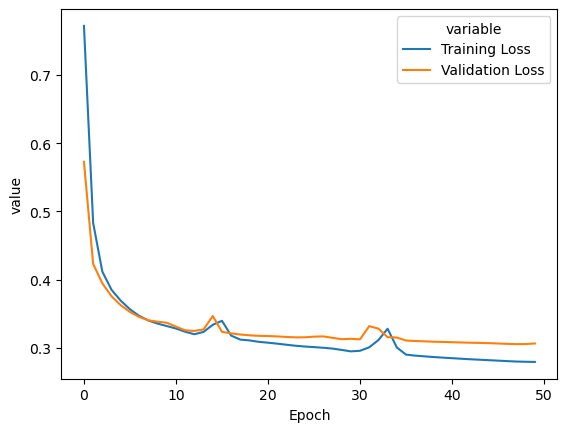

In [58]:
# Plot training curves
plot_data = pd.DataFrame(
    {
        "Epoch": [x for x in range(0,len(rnn_train_losses))],
        "Training Loss": rnn_train_losses,
        "Validation Loss": rnn_test_losses
    }
)
sns.lineplot(x='Epoch', y='value', hue='variable', data=pd.melt(plot_data, ['Epoch']))

In [96]:
# Look at predictions
# Note zeros in MAPE cause overflow
print(f"MAPE: {metrics.mean_absolute_percentage_error(rnn_labels[:13], rnn_preds[:13])}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(rnn_labels, rnn_preds))}")
print(f"MAE: {metrics.mean_absolute_error(rnn_labels, rnn_preds)}")

print(f"MAPE: {metrics.mean_absolute_percentage_error(avg_seq_labels / 1e20, avg_seq_preds / 1e20)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(avg_seq_labels, avg_seq_preds))}")
print(f"MAE: {metrics.mean_absolute_error(avg_seq_labels, avg_seq_preds)}")

MAPE: 3.2734146118164062
RMSE: 3.44891619682312
MAE: 2.10748553276062
MAPE: 0.0002097583783324808
RMSE: 5.9839582443237305
MAE: 4.657571792602539


<Axes: ylabel='Count'>

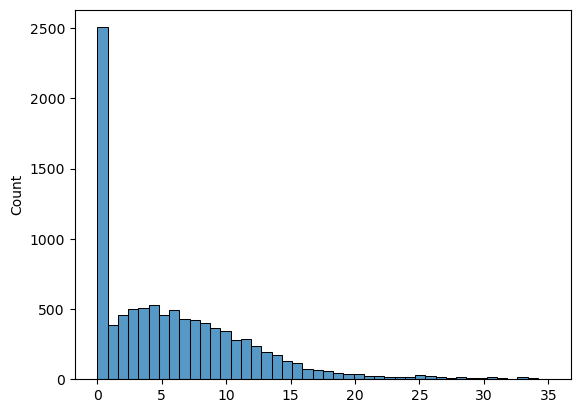

In [81]:
sns.histplot(rnn_labels)

<Axes: ylabel='Count'>

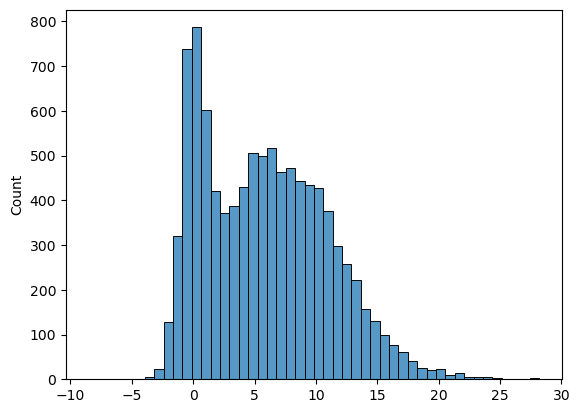

In [82]:
sns.histplot(rnn_preds)